In [200]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [201]:
# Load Data
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [202]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [203]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [204]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [205]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [206]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape    


(torch.Size([614, 8]),
 torch.Size([614]),
 torch.Size([154, 8]),
 torch.Size([154]))

In [207]:
class diabetesDense(nn.Module):
    def __init__(self):
        super(diabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model, loss function, and optimizer
model = diabetesDense()

In [208]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [209]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [210]:
import torch

# 변수 초기화
train_losses = []
test_accuracies = []

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # 데이터를 GPU로 이동 및 dtype 변환
        labels = labels.view(-1, 1)  # BCEWithLogitsLoss를 사용할 경우 labels 크기 맞추기

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            labels = labels.view(-1, 1)

            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  # 이진 분류에서는 0.5 기준으로 예측값 결정
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 0.6941, Accuracy: 72.73%
Epoch 2/30, Loss: 0.6582, Accuracy: 69.48%
Epoch 3/30, Loss: 0.6165, Accuracy: 69.48%
Epoch 4/30, Loss: 0.5902, Accuracy: 72.08%
Epoch 5/30, Loss: 0.5475, Accuracy: 80.52%
Epoch 6/30, Loss: 0.5158, Accuracy: 79.22%
Epoch 7/30, Loss: 0.4885, Accuracy: 76.62%
Epoch 8/30, Loss: 0.4925, Accuracy: 77.92%
Epoch 9/30, Loss: 0.4689, Accuracy: 77.92%
Epoch 10/30, Loss: 0.4801, Accuracy: 77.27%
Epoch 11/30, Loss: 0.4810, Accuracy: 77.27%
Epoch 12/30, Loss: 0.4696, Accuracy: 78.57%
Epoch 13/30, Loss: 0.4561, Accuracy: 77.92%
Epoch 14/30, Loss: 0.4642, Accuracy: 78.57%
Epoch 15/30, Loss: 0.4656, Accuracy: 78.57%
Epoch 16/30, Loss: 0.4575, Accuracy: 79.22%
Epoch 17/30, Loss: 0.4671, Accuracy: 79.22%
Epoch 18/30, Loss: 0.4470, Accuracy: 80.52%
Epoch 19/30, Loss: 0.4529, Accuracy: 80.52%
Epoch 20/30, Loss: 0.4346, Accuracy: 81.17%
Epoch 21/30, Loss: 0.4348, Accuracy: 82.47%
Epoch 22/30, Loss: 0.4373, Accuracy: 82.47%
Epoch 23/30, Loss: 0.4515, Accuracy: 82.4

In [211]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 모델 평가 모드로 변경
model.eval()

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# 결과 저장
all_labels = []
all_predictions = []

# 평가 데이터 처리
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # 데이터 GPU로 이동 및 dtype 변환
        labels = labels.view(-1, 1)  # BCEWithLogitsLoss 사용 시 크기 맞추기

        outputs = model(inputs)

        # 이진 분류일 경우 확률 기준으로 예측
        predicted = (outputs >= 0.5).float()  # 0.5 기준으로 분류

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[94 13]
 [13 34]]
F1 Score: 0.83
Precision: 0.83
Recall: 0.83
Specificity: 0.80


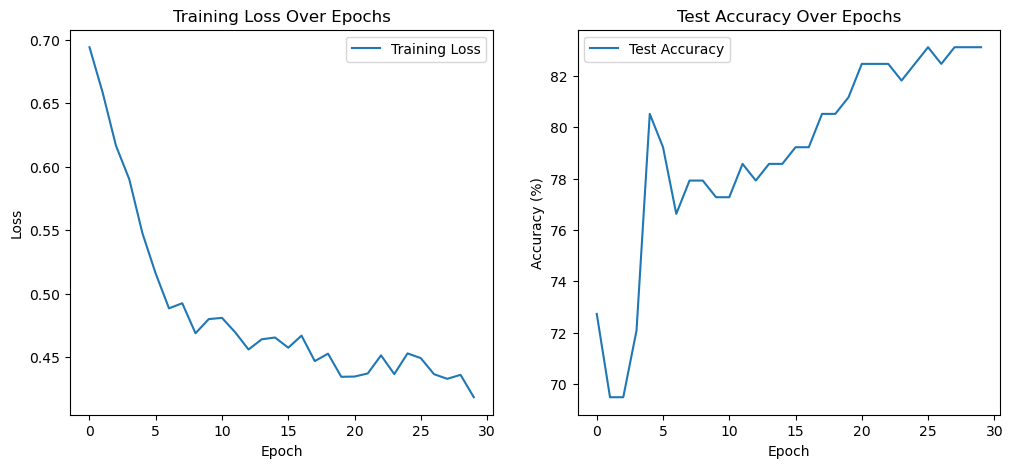

In [212]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()